# Interpret CNN model

In [ ]:
# default_exp interp.visual

In [ ]:
# export
from pathlib import Path
from PIL import Image
from typing import Callable, List, Dict
import torch
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
from torchvision.models import resnet18
from torchvision import transforms as tfm

In [ ]:
model = resnet18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/salvor/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
IMAGES = list(Path("../test/img/Nature/").iterdir())

In [ ]:
model(basic_trans(Image.open(IMAGES[0]))[None,...])

torch.Size([1, 1000])

In [ ]:
def simple_to_tensor(
        size: int = 224,
        mean_: List[float] = [0.485, 0.456, 0.406],
        std: List[float] = [0.229, 0.224, 0.225],
        img_transforms: List = [],
        tensor_tranforms: List = [],
        return_batch: bool = False, 
    ) -> Callable:
    trans = tfm.Compose([
        tfm.Resize(size),
        *img_transforms,
        tfm.ToTensor(),
        *tensor_tranforms,
        tfm.Normalize(mean=mean_, std=std)
    ])
    if return_batch:
        def to_tensor(path):
            with Image.open(str(path)) as img:
                return trans(img.convert('RGB'))[None,...]
    else:
        def to_tensor(path):
            """
            """
            with Image.open(str(path)) as img:
                return trans(img.convert('RGB'))
    return to_tensor

In [ ]:
basic_trans = simple_to_tensor(return_batch=True)

In [ ]:
tensor = basic_trans(IMAGES[0])
with torch.no_grad():
    y_ = model(tensor)[0]

In [ ]:
def get_features(self, x):
    # See note [TorchScript super()]
    with torch.no_grad():
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [ ]:
def to_8b(x):
    min_ = x.min()
    max_ = x.max()
    return (256*(x-min_)/(max_-min_)).astype(np.int8)

In [ ]:
features = get_features(model, tensor)[0]
features.shape

torch.Size([512, 7, 7])

In [ ]:
significance = y_.argsort().flip(dims=(0,))

In [ ]:
def get_feature_importance(idx=0):
    with torch.no_grad():
        return model.fc.weight.data[significance[idx]][:,None,None]*features

In [ ]:
feature_importance = get_feature_importance(0)

In [ ]:
feature_rank = feature_importance.sum(-1).sum(-1).argsort().flip(dims=(0,))

In [ ]:
img = Image.open(IMAGES[0])

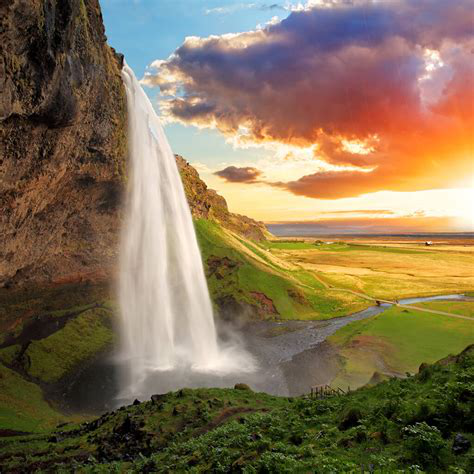

In [ ]:
img

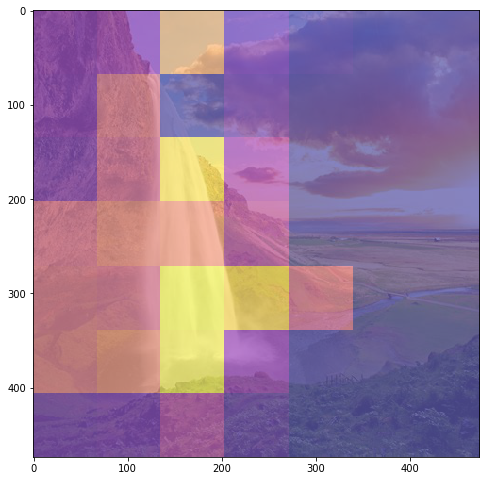

In [ ]:
colormap = 'plasma'
fig = plt.figure(figsize=(8,16))

ax2 = plt.subplot(aspect='equal')
ax2.imshow(img,alpha=.5,)

hm = ax2.imshow(Image.fromarray(to_8b(feature_importance[feature_rank[0],...].numpy()),
                                mode="L").resize((img.height,img.width)),
                alpha=.5, cmap='plasma')
plt.show()